<a href="https://colab.research.google.com/github/noeliaof/CloudSegmentation/blob/main/mytest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Cloud cover Segmentation

This jupyter notebook implements a cloud segmentation task from satellite images. 
The data consists on 12 images, each  with a tile_id and  date will be the unique identifier. For each image, there is a corresponding cloud mask with the same identificator. The images have 11 channels/bands. For simplicity and to save space and memory the tiles are also available as RGB only 3-bands (500mb instead of 2.5GB tif files).

To make things easier (in terms of memory), the images_RGB will be used for the task of cloud segmentation. 

To segment clouds, I decided to use a ML approach, which is explained in this jupyter notebook. The main steps can be summarised as follows:

1. Before starting, I decided to use 11 images and masks for training and validation, and I left one image for testing purposes.  
2. As the original images are: 10980x10980 pixels, which is too large to train the model, the images and masks are divided into small patches. This steps is performed using "patchify", which split a large image into a number of patches with a selected size (i.e., 256x256).  
3. Once the patches are created, a proper dataset to train the model is created.
4. A simple implementation of the classic UNet is used for the image segmentation.


### Organization and technical aspects:

The main functions for processing the data and the model are in the *py files provided along this jupyter notebook.
The python packages used are in requiments.txt. 

The jupyter notebook has been run in a google colab prob, which provides more compute units.


In [ ]:
# Uncomment this cell if using google colab 

In [1]:
from google.colab import drive
drive.mount('/gdrive/')


Drive already mounted at /gdrive/; to attempt to forcibly remount, call drive.mount("/gdrive/", force_remount=True).


In [2]:
# Set the right path
!cd '/gdrive/MyDrive/CloudSegmentation/'

In [ ]:
!pip install -r '/gdrive/MyDrive/CloudSegmentation/requirements.txt'

In [3]:
# I had some problems with matplotlib in colab, so I had to downgrade the version
#!pip install matplotlib==3.2.2

In [4]:
cd '/gdrive/MyDrive/CloudSegmentation/'

/gdrive/MyDrive/CloudSegmentation


### Import libraries

In [5]:
from matplotlib import pyplot as plt
import os
import rasterio
import numpy as np
import cv2
from patchify import patchify, unpatchify
import albumentations as A
from torch.utils.data import Dataset, DataLoader, sampler
from sklearn.preprocessing import MinMaxScaler
from tqdm import *
import time
from utils import *
from Unet import *

### Data exploration

In [ ]:
# Open an image and the corresponding mask
file_img = 'images/train/Sentinel2L2A_sen2cor_21NYC_20171206_clouds=43.6%_area=100%.tif'
file_rgb_img = 'images_RGB//train/Sentinel2L2A_sen2cor_21NYC_20171206_clouds=43.6%_area=100%_RGB.tif'
file_mask = 'mask/train/cloud_mask_21NYC_20171206_clouds=84%.tif'

In [ ]:
# No bands specified
img, metadata = read_crop(file_img, None, None)
img_rgb, metadata = read_crop(file_rgb_img, None, None)
mask, metadata = read_crop(file_mask, None, None)

In [ ]:
metadata

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': None,
 'width': 10980,
 'height': 10980,
 'count': 1,
 'crs': CRS.from_epsg(32621),
 'transform': Affine(10.0, 0.0, 699960.0,
        0.0, -10.0, 300000.0)}

In [ ]:
print(mask.shape)
print(img.shape)
print(img_rgb.shape) 

(1, 10980, 10980)
(11, 10980, 10980)
(3, 10980, 10980)


In [ ]:
# Visualise all bands

In [ ]:
def show_images(images, cols = 1):

    n_images = len(images)
    titles = ['Band %d' % i for i in range(1,n_images + 1)]
    plt.figure(figsize=(20,10))
    
    for i, (image, title) in enumerate(zip(images, titles)):
        plt.subplot(int(len(images) / cols + 1), cols, i + 1)
        plt.imshow(image)
        plt.title(title)

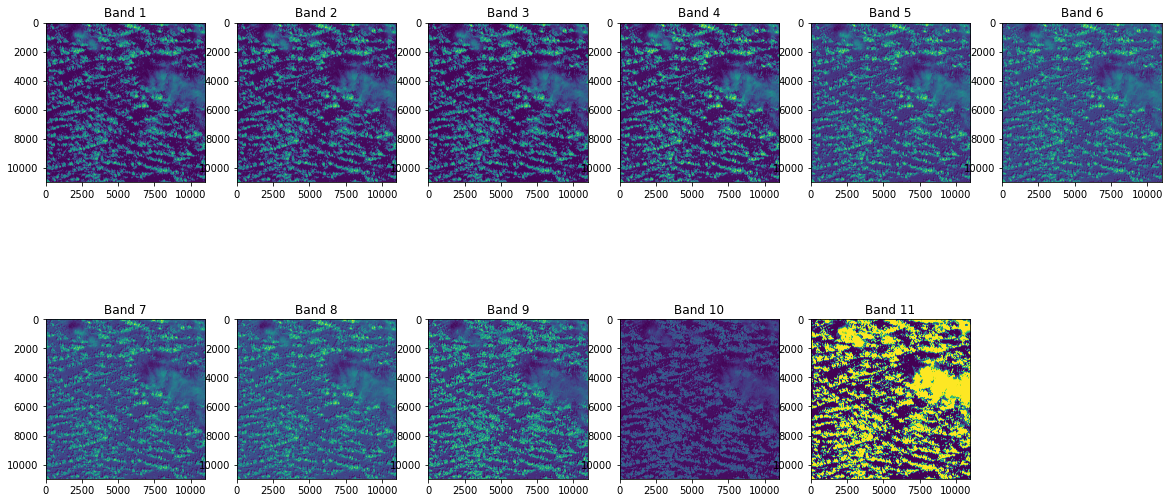

In [ ]:
show_images(img,cols=6)

### Let's first visualize just RGB  and the corresponding mask

Text(0.5, 1.0, 'Cloud Mask')

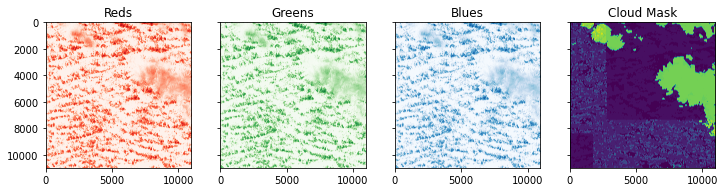

In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, sharex=True, sharey=True, figsize = (12,12))
img1 = ax1.imshow(img_rgb[0], cmap = 'Reds')
ax1.axis('on') 
ax1.set_title("Reds")

img2 = ax2.imshow(img_rgb[1], cmap = 'Greens')
ax2.axis('on')    
ax2.set_title("Greens")

img3 = ax3.imshow(img_rgb[2], cmap = 'Blues')
ax3.axis('on')
ax3.set_title("Blues")

msk = ax4.imshow(np.transpose(mask, (1,2,0)))
ax4.set_title("Cloud Mask")

## Segmentation part

In [ ]:
# From now and to make it easier, only RGB images are used

In [6]:
# Set the paths
PATH_train = 'images_RGB/train/'
PATH_mask_train = 'mask/train/'

In [7]:
PATH_test = 'images_RGB/test/'
PATH_mask_test = 'mask/test/'

### 1. Cut large images into small patches


In [8]:
# For that, I use patchify. Let's have a look to one example.
# For this example, I will use a "big" patch size, only for visualization purposes. 
# Note that for the training, a smaller patch size (244) is used.

In [ ]:
N = img_rgb.shape[0] # number of channels
patch_size = 2816 #
patches_img = patchify(img_rgb, (N, patch_size, patch_size), step=patch_size)  #Step=2816 for 2816 patches means no overlap           

In [ ]:
print(patches_img.shape) 

(1, 3, 3, 3, 2816, 2816)


In [ ]:
# drop extra dimension added by patchify
patches_img = patches_img[0]

In [ ]:
patches_img.shape

(3, 3, 3, 2816, 2816)

Text(0.5, 1.0, 'large image')

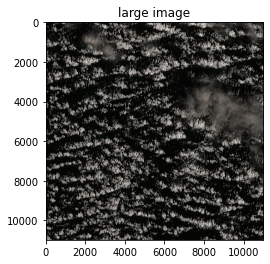

In [ ]:
# let's see the patches
plt.imshow(np.transpose(img_rgb/np.amax(img_rgb), (1,2,0))) # for plotting
plt.title('large image')

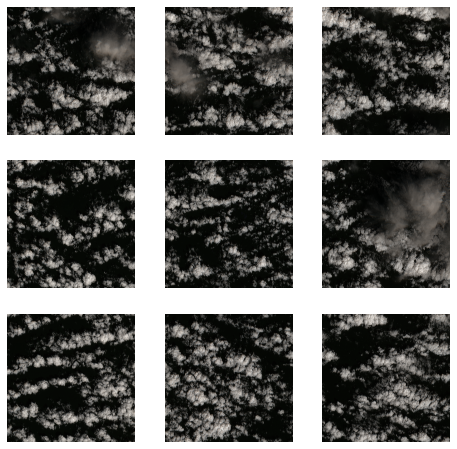

In [ ]:
# let's see the patches
fig = plt.figure(figsize=(8, 8))
rows= 3
columns=3
k=1
for i in range(0,3):
    for j in range(0,3):
        i_img = patches_img[i,j,:,:,:]
        i_img = np.transpose(i_img/np.amax(i_img), (1,2,0))
        fig.add_subplot(rows, columns, k)
        plt.imshow(i_img)
        plt.axis('off')
        k = k +1
plt.show()


In [9]:
# define patch size 
patch_size = 244 # With this size we get a total of 45x45 patches for the original size 10980
bands=[1,2,3]
all_small_patches = prepare_patches(PATH_train, patch_size, bands, PATH_OUT=None, masks = False)

In [10]:
# Now process the masks
bands_masks=[1]

In [11]:
all_small_masks = prepare_patches(PATH_mask_train, patch_size, bands_masks, masks = True)

In [12]:
print(all_small_patches.shape)
print(all_small_masks.shape)
print("Pixel values in the mask are: ", np.unique(all_small_masks))
print("total values in the mask are: ", len(np.unique(all_small_masks)))

(6075, 3, 244, 244)
(6075, 1, 244, 244)
Pixel values in the mask are:  [  0   1   3   7  11  15  16  17  19  23  27  31  33  35  39  43  47  49
  51  55  59  63  65  67  71  75  79  97  99 103 107 111 113 115 123 127
 131 135 139 143 147 151 155 159 163 171 175 187 191]
total values in the mask are:  49


In [13]:
def vis_patch(image, mask):
    
    image = np.clip(image, 0, 2000)/2000.0
    
    f, ax = plt.subplots(1, 2, figsize=(12, 4))
    
    ax[0].imshow(np.transpose(image, (1,2,0)))
   
    mask = np.clip(mask, 0, 50)/50.0 # we put max to 50 here but this is image specific
    ax[1].imshow(np.transpose(np.repeat(mask, [3], axis=0),(1,2,0))) #simple hack to show 1 channel as 3, we just copy it 3 times :)

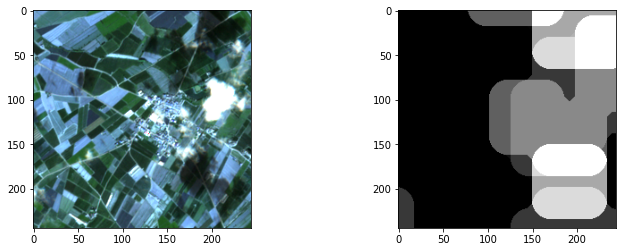

In [14]:
vis_patch(all_small_patches[1500,:,:,:], all_small_masks[1500,:,:,:])

In [17]:
def visualize(image, mask, original_image=None, original_mask=None):
    fontsize = 18
    
    if original_image is None and original_mask is None:
        f, ax = plt.subplots(2, 1, figsize=(4, 4))

        ax[0].imshow(image[0,:,:])
        ax[1].imshow(mask[0,:,:])
    else:
        f, ax = plt.subplots(2, 2, figsize=(8, 8))

        ax[0, 0].imshow(original_image[0,:,:])
        ax[0, 0].set_title('Original image', fontsize=fontsize)
        
        ax[1, 0].imshow(original_mask[0,:,:])
        ax[1, 0].set_title('Original mask', fontsize=fontsize)
        
        ax[0, 1].imshow(image[0,:,:])
        ax[0, 1].set_title('Transformed image', fontsize=fontsize)
        
        ax[1, 1].imshow(mask[0,:,:])
        ax[1, 1].set_title('Transformed mask', fontsize=fontsize)

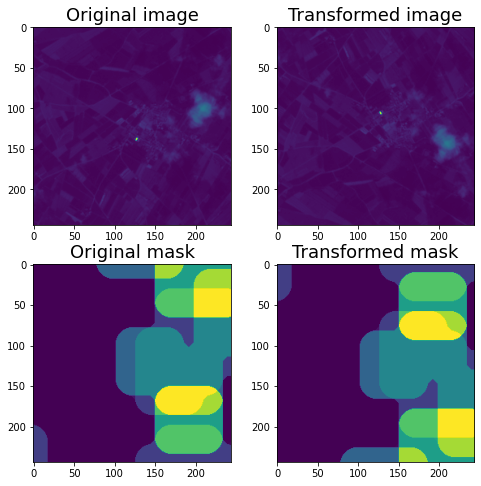

In [28]:
import albumentations as A

aug = A.Compose([
    A.VerticalFlip(p=1.5),              
    A.RandomRotate90(p=0.5)]
)

img = all_small_patches[1500,:,:,:]
msk = all_small_masks[1500,:,:,:]
augmented = aug(image=img, mask=msk)
image_light = augmented['image']
mask_light = augmented['mask']
visualize(image_light, mask_light, original_image=img, original_mask=msk)

###  Data preparation

In [15]:
# Normalize the input data
scaler = MinMaxScaler()
input_img = scaler.fit_transform(all_small_patches.reshape(-1, all_small_patches.shape[-1])).reshape(all_small_patches.shape)

In [16]:
class CloudDataset(Dataset):
    """Class-cloud for the dataloader"""
    def __init__(self, image, mask, transforms = None):
       
        self.image = image
        self.mask = mask
        self.transforms = transforms
       
    def __getitem__(self, idx):
        
        img = self.image[idx]
        mask = self.mask[idx]
        # To binarise the output: cloud:1 no cloud:0
        mask = np.where(mask>1, 1, 0).astype(mask.dtype)
        if self.transforms:
            augmented = self.transforms(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask']
        
        return img, mask

    def __len__(self):
        return len(self.image)

In [17]:
data = CloudDataset(input_img, all_small_masks)

In [18]:
x, y = data[100]
x.shape, y.shape

((3, 244, 244), (1, 244, 244))

##### Split the data into train and validation subsets

In [19]:
train_size = int(0.8 * len(all_small_patches))
valid_size = len(all_small_patches) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(data, [train_size, valid_size])

In [20]:
train_dl = DataLoader(train_dataset, batch_size=12)
valid_dl = DataLoader(valid_dataset, batch_size=12)

In [21]:
# let's look at the shapes
xb, yb = next(iter(train_dl))
xb.shape, yb.shape

(torch.Size([12, 3, 244, 244]), torch.Size([12, 1, 244, 244]))

#### Load the Model UNet

In [22]:
model = UNet(3,1)

In [23]:

epochs=10
#loss_fn = nn.CrossEntropyLoss() # when using multi-class target
# Loss function: Binary cross-entropy with logits loss combines a Sigmoid layer and the BCELoss in one single class.
# For simplicity I used a binary target 0-1
loss_fn = nn.BCEWithLogitsLoss() 
# Setting up optimizer
optimizer = torch.optim.Adam(params = model.parameters(), lr=0.01)

In [24]:
# free some memory if needed
torch.cuda.empty_cache()

In [25]:
def train(model, train_dl, valid_dl, loss_fn, optimizer, acc_fn, epochs):

    """Train the model
        Args: 
        train_dl: training subset
        valid_dl: validation subset
        optimizer: Optimizer, in this case Adam
        acc_fn and loss_fc: accuracy and loss_function
        epoch: number of epochs"""


    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    
    print(device)

    train_loss, valid_loss = [], []
    train_acc, valid_acc = [], []

    best_acc = 0.0

    dataloader = train_dl
    val_loader = valid_dl
    
    print('Training')
    print('=' * 60)
    model.to(device)
    model.train()
    #start = time.time()

    for epoch in range(1,epochs+1):
        loss_temp = 0.0
        acc_temp = 0.0
        time.sleep(0.2)
        with tqdm(dataloader,unit='batch') as pbar:
            # iterate over data
            pbar.set_description('Epoch: {}/{}'.format(epoch,epochs))
            for data in pbar:
                x,y = data
                x, y = x.to(device), y.to(device)
                
                # forward pass
                outputs = model(x.float())

                # compute loss
                loss = loss_fn(outputs.to(device), y.type(torch.FloatTensor).to(device)).to(device)

                # zero the gradients
              
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

                #compute the accuracy
                acc = acc_fn(outputs.to(device), y.to(device))

                acc_temp  += acc
                loss_temp += loss 

                pbar.set_postfix(loss=loss.item(), accuracy=100. * acc.item())
   
              
            running_loss = loss_temp / len(dataloader)
            running_acc = acc_temp / len(dataloader)
            pbar.set_postfix(loss=running_loss, accuracy=100. *running_acc)
            #print('Epoch {} Loss: {:.4f} Acc: {}'.format(epoch, running_loss, running_acc))

            print('Validation')
            print('=' * 60)

            val_loss = 0
            val_acc = 0

            for val_data in val_loader:
                x_val, y_val = val_data
                x_val, y_val = x_val.to(device), y_val.to(device)

                # forward pass
                val_outputs = model(x_val.float())
                with torch.no_grad():
                    # compute loss
                    val_loss_temp = loss_fn(val_outputs.to(device), y_val.type(torch.FloatTensor).to(device)).to(device)
                    val_acc_temp = acc_fn(val_outputs.to(device), y_val.to(device)).to(device)

                    val_loss += val_loss_temp
                    val_acc += val_acc_temp

            running_val_loss = val_loss/len(val_loader)
            running_val_acc = val_acc/len(val_loader)

            print('Validation Loss: {}  Validation Acc: {}'.format(running_val_loss, running_val_acc))
            train_loss.append(running_loss) 
            train_acc.append(running_acc)

            valid_loss.append(running_val_loss)
            valid_acc.append(running_val_acc)
 
   
    train_loss_ = [train_loss[i].cpu().detach().numpy() for i in range(len(train_loss))]
    valid_loss_ = [valid_loss[i].cpu().detach().numpy() for i in range(len(valid_loss))]
    train_acc_ = [train_acc[i].cpu().detach().numpy() for i in range(len(train_acc))]
    valid_acc_ = [valid_acc[i].cpu().detach().numpy() for i in range(len(valid_acc))]

    # save the model 
    model_save_name = 'model.pt'
    path = F"/gdrive/MyDrive/CloudSegmentation/{model_save_name}"
    torch.save(model.state_dict(),path)
    
    return train_loss_ , valid_loss_, train_acc_, valid_acc_  

def acc_metric(predb, yb):
    return ((predb > 0.5) == yb).float().mean()
    #return (predb.argmax(dim=1) == yb).float().mean()

Train the model

In [26]:
train_loss, valid_loss, train_acc, valid_acc = train(model, train_dl, valid_dl, loss_fn, optimizer, acc_metric, epochs = 10)

cuda:0
Training


Epoch: 1/10: 100%|██████████| 405/405 [07:13<00:00,  1.07s/batch, accuracy=91.7, loss=0.232]


Validation
Validation Loss: 0.3162948489189148  Validation Acc: 0.857730507850647


Epoch: 2/10: 100%|██████████| 405/405 [07:15<00:00,  1.08s/batch, accuracy=92, loss=0.203]


Validation
Validation Loss: 0.2795153856277466  Validation Acc: 0.8717216849327087


Epoch: 3/10: 100%|██████████| 405/405 [07:15<00:00,  1.07s/batch, accuracy=93.1, loss=0.18]


Validation
Validation Loss: 0.2696535289287567  Validation Acc: 0.8734731078147888


Epoch: 4/10: 100%|██████████| 405/405 [07:14<00:00,  1.07s/batch, accuracy=93.3, loss=0.181]


Validation
Validation Loss: 0.2611202299594879  Validation Acc: 0.8804485201835632


Epoch: 5/10: 100%|██████████| 405/405 [07:14<00:00,  1.07s/batch, accuracy=93.2, loss=0.179]


Validation
Validation Loss: 0.2582654058933258  Validation Acc: 0.8823439478874207


Epoch: 6/10: 100%|██████████| 405/405 [07:13<00:00,  1.07s/batch, accuracy=93.2, loss=0.169]


Validation
Validation Loss: 0.25057822465896606  Validation Acc: 0.8852352499961853


Epoch: 7/10: 100%|██████████| 405/405 [07:14<00:00,  1.07s/batch, accuracy=93.2, loss=0.164]


Validation
Validation Loss: 0.2489510029554367  Validation Acc: 0.8870100975036621


Epoch: 8/10: 100%|██████████| 405/405 [07:14<00:00,  1.07s/batch, accuracy=93.1, loss=0.158]


Validation
Validation Loss: 0.24442891776561737  Validation Acc: 0.8875913023948669


Epoch: 9/10: 100%|██████████| 405/405 [07:14<00:00,  1.07s/batch, accuracy=93.2, loss=0.162]


Validation
Validation Loss: 0.24236592650413513  Validation Acc: 0.8879733085632324


Epoch: 10/10: 100%|██████████| 405/405 [07:13<00:00,  1.07s/batch, accuracy=93.3, loss=0.154]


Validation
Validation Loss: 0.23990702629089355  Validation Acc: 0.8878365159034729


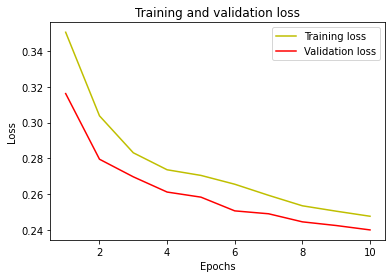

In [27]:
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'y', label='Training loss')
plt.plot(epochs, valid_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

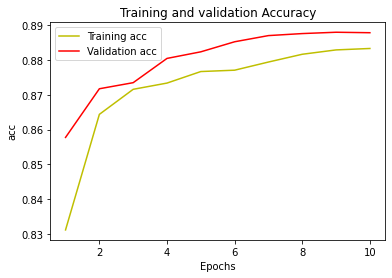

In [28]:
plt.plot(epochs, train_acc, 'y', label='Training acc')
plt.plot(epochs, valid_acc, 'r', label='Validation acc')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('acc')
plt.legend()
plt.show()

In [ ]:
# Overfiting problem: I might want to test chaning the learning rate or other strategies to deal with it.

In [ ]:
### Predictions 

In [8]:
# load the model 
state_dict = torch.load('/gdrive/MyDrive/CloudSegmentation/model.pt')

In [13]:
model.load_state_dict(state_dict)

<All keys matched successfully>

In [33]:
# To get a large predicted image I applied the following strategie:
# 1. First, the large image must be splitted into small patches
# 2. Predict small patches
# 3. Use unpachify to reconstruct the large image

# For simplicity, I will use one image from the testing folder
# need to crop to make a regular number of patches to pass through the function unpatchify
(px, py, w, h) = 228, 228, 10752, 10752 #left, top, right-left, bottom-top
img_test, metadata = read_crop(PATH_test + 'Sentinel2L2A_sen2cor_58KFC_20181021_clouds=1.2%_area=100%_RGB.tif', None , None)
mask_test, metadata = read_crop(PATH_mask_test + 'cloud_mask_58KFC_20181021_clouds=5%.tif', None , None)


In [36]:
patches_test = patchify(img_test, (3, 244, 244), step=244)
mask_patches_test = patchify(mask_test, (1, 244, 244), step=244)
print(mask_patches_test.shape)
#check
# x = unpatchify(mask_patches_test, mask_test.shape)
# remove extra dimension
#patches_test = patches_test[0]
#mask_patches_test = mask_patches_test[0]

(1, 45, 45, 1, 244, 244)


In [30]:
# Prepare the data accordingly
scaler = MinMaxScaler()
input_test = scaler.fit_transform(patches_test.reshape(-1, patches_test.shape[-1])).reshape(patches_test.shape)

In [31]:
input_test.shape

(42, 42, 3, 256, 256)

In [ ]:
#data_test = CloudDataset(input_test, mask_test)
#test_dl = DataLoader(data_test, batch_size=12)

In [ ]:
predicted_patches = []
for i in range(input_test.shape[0]):
    for j in range(input_test.shape[1]):
        print(i,j)
        
        single_patch = input_test[i,j,:,:,:]
        single_patch_input=np.expand_dims(single_patch, 0)
        single_patch_input = torch.as_tensor(single_patch_input)
        
        single_patch_prediction = model(single_patch_input.float())
        #Predict and threshold for values above 0.5 probability
        single_patch_prediction =  np.array(single_patch_prediction> 0.5).astype(np.uint8)
        predicted_patches.append(single_patch_prediction)

In [ ]:
predicted_patches = np.array(predicted_patches)
predicted_patches.shape

(1764, 1, 1, 256, 256)

In [ ]:
predicted_patches_reshaped = np.reshape(predicted_patches, (mask_test.shape[0], mask_test.shape[1], 256,256) )

In [ ]:
mask_test.shape

(1, 10980, 10980)

In [ ]:
predicted_patches_reshaped.shape

(42, 42, 256, 256)

In [ ]:
output_height = mask_test.shape[1] -(mask_test.shape[2] - 256) % 1
output_width = mask_test.shape[1] -(mask_test.shape[2] - 256) % 1
output_shape = (output_height, output_width, 1)

In [ ]:
print(output_shape)

(10980, 10980, 1)


In [ ]:
reconstructed_mask = unpatchify(predicted_patches_reshaped, (1,10980,10980))

AssertionError: ignored

In [ ]:
single_patch = input_test[0,0,:,:,:]

In [ ]:
single_patch_input=np.expand_dims(single_patch, 0)
single_patch_input.shape

(1, 3, 256, 256)

In [ ]:
single_patch_input = torch.as_tensor(single_patch_input)

In [ ]:
single_patch_input.shape

torch.Size([1, 3, 256, 256])

In [ ]:
p=model(single_patch_input.float())

In [ ]:
 np.array(p> 0.5).astype(np.uint8).shape

(1, 1, 256, 256)

In [ ]:
test_dataloader = valid_dl
test_data, mask_data = next(iter(test_dataloader))
    
model.to('cpu')

In [ ]:
test_data.shape

torch.Size([12, 3, 256, 256])

In [ ]:
y_hat = model(test_data.float())

In [ ]:
p = torch.max(y_hat, 1)[1]

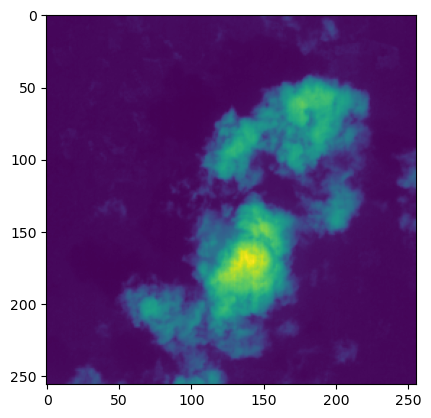

In [ ]:
data = test_data[0]
plt.imshow(data[0,:,:])

In [ ]:
def plot_img(test_dataloader,model,n):
    
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    
    test_data = next(iter(test_dataloader))
    test_data, mask_data = next(iter(test_dataloader))
    
    model.to(device)
    y_hat = model(test_data.float())
    
    if n>len(test_dataloader):
        n = len(test_dataloader)
        
    for j in range(n):
        plt.figure(figsize = (10, 8))
        plt.subplot(j+1,3,1)
        data = test_data[j]
        #data = np.clip(data, 0, 1)
        plt.imshow(np.transpose(data, (1,2,0)))
        plt.title('Pre-processed Original Image')
        plt.axis('off')

        plt.subplot(j+1,3,2)
        mask = mask_data[j]
        plt.imshow(np.transpose(mask, (1,2,0)))
        plt.title('Original Mask')
        plt.axis('off')

        plt.subplot(j+1,3,3)
        pred = y_hat.argmax(1)
        pred = pred[j]
        plt.imshow(pred)
        plt.title('Predicted Mask')
        plt.axis('off')

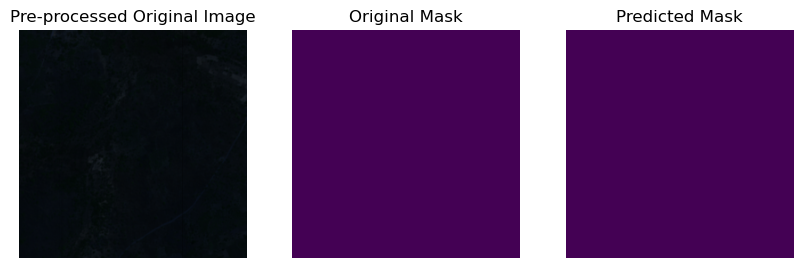

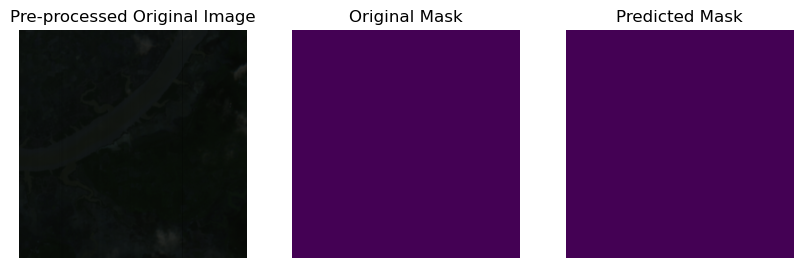

In [ ]:
plot_img(valid_dl, model, n=2)